# Analysis of HSC moderation of tied marks

## Summary
If school based assessment results in tied marks for first place, there is an overall benefit to the moderated HSC scores of the class if some means is used to separate the students. However, this process advantages highly ranked students at the expense of lower ranked students and has no educational jsutification.

## Rationale

Every year, around the end of term 3, there is a lot of discussion around the subject of what to do if two HSC students are tied for first place after school based assessment. This discussion arises from a perception that the [algorithm used by NESA to moderate school marks](https://educationstandards.nsw.edu.au/wps/portal/nesa/11-12/hsc/about-HSC/moderation), in light of the students' HSC examination performance, disadvantages students if tied results ae submitted. One school of thought dictates that students should be separated by some means, valid ortherwise. The alternative view is that separating students has no educational nor moral justification.

This analysis focusses on the effect of spearating students on their final scores and the scores of other students in the class. Questions of whether such actions are justified are addressed at the end of the analysis.

## Method
The effect of NESA moderation on tied marks is explored using a Python based simulation. A class of size `n` is assumed to have a normally distributed school based assessment with a specified `mean` and standard variation, `sd`. In one case, `school_scores_tied`, the scores are manipulated to ensure that the two top students are equal. In the alternative case `school_scores_sep`, the scores are separated by adding 1 mark to the score of one of the top students.

HSC examination scores are assumed to have a normally distributed variation from the school assessment scores with a standard deviation of `sd_imp`. The parameter `mean_imp` can be used to specify a mean improvement in examination scores relative to school assessment - this parameter can be positive, negative or 0.

This analysis is initially completed once and the moderated scores of the tied group is compared to that of the spearated group to allow a visual appreciation of the effect of moderation. Because of the random generation, the results of this analysis change each time the analysis is run.

The analysis is then completed `runs` times, and the average effect of the moderation process on the scores of the tied and separated groups are compared by rank.

### Moderation algorithm

Moderation is achieved through a second order polynomial whereby the input x values are the school assessment scores and the output y values are the moderated schores. The coefficients of the polynomial are determined by fitting a curve to the following 3 [x,y] pairs:

- [school minimum score, exam minimum score]
- [school mean score, exam mean score]
- [school maximum score, exam maximum score]

### Analysis
First we need to set up the python environment - you can ignore this stuff

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# function to calculate the stats needed to fit the polynomial
def get_stats(in_array, tied = False):
    if tied:
        # in the case of tied rankings NESA averages the two top exam marks before fitting the polynomial
        # need to calculate this tied mark before calculating poly_fit_tied
        top_mark = np.rint((in_array[n-2] + in_array[n-1])/2)
        stats = np.array([np.amin(in_array), np.rint(np.mean(in_array)), top_mark])
    else:
        stats = np.array([np.amin(in_array), np.rint(np.mean(in_array)), np.amax(in_array)])
    return stats

Assumptions which can be adjusted by altering the variables in the code box below:

- n = 12; the number of students in the class
- mean = 65; the mean school assessment score
- sd = 15; the standard deviation of the school assessment scores
- school_max = 95; the maximum value for the school based asessment. Keep less than 100
- mean_imp = 5; the mean of the improvement in HSC examination scores compared to school based assessment. This can be set to a positive or negative value.
- sd_imp = 7; the standard deviastion of the improvement in HSC examination scores compared to school based assessment. 


In [4]:
n = 12
mean = 65
sd = 15
mean_imp = 5
sd_imp = 7
school_max = 95

Create the school assessment array consisting of n-1 integer scores (we will limit the maximum score to `school_max`).

In [5]:
school_scores = np.random.normal(mean, sd, n-1)
school_scores = np.rint(school_scores) #convert to integer scores
# make sure no value is greater than school_max - 1
school_scores = np.minimum(school_scores, school_max-1)
school_scores = np.sort(school_scores)

print(f'n-1 school scores: {school_scores}')

n-1 school scores: [44. 53. 54. 56. 64. 67. 69. 72. 72. 80. 93.]


Add the top score. We create 1 group with a tied top score (`school_score_tied`), and a second group with a top score that hase been increased by one (`school_score_sep`).

In [6]:
school_score_tied = np.append(school_scores, np.amax(school_scores))
print(f'tied school scores:      {school_score_tied}')
school_score_sep = np.append(school_scores, np.amax(school_scores)+1)
print(f'separated school scores: {school_score_sep}')

tied school scores:      [44. 53. 54. 56. 64. 67. 69. 72. 72. 80. 93. 93.]
separated school scores: [44. 53. 54. 56. 64. 67. 69. 72. 72. 80. 93. 94.]


Create an array of HSC exam scores by randomly varying the the school scores by a mean of `mean_imp` with a standard deviation of `sd_imp`. A crude limit is imposed to ensure that no exam score exceeds 99.

In [7]:
exam_scores = school_score_tied + np.random.normal(mean_imp, sd_imp, n)
exam_scores = np.minimum(exam_scores, 99)
exam_scores = np.rint(exam_scores)
print(f'tied school scores:      {school_score_tied}')
print(f'separated school scores: {school_score_sep}')
print(f'exam scores:             {exam_scores}')

tied school scores:      [44. 53. 54. 56. 64. 67. 69. 72. 72. 80. 93. 93.]
separated school scores: [44. 53. 54. 56. 64. 67. 69. 72. 72. 80. 93. 94.]
exam scores:             [52. 58. 56. 54. 63. 69. 64. 74. 78. 83. 99. 99.]


Moderate the school scores by adjusting the school assessment minimum, mean and maximum to the exam score minimum, mean and maximum then moderating the school assessment using a second order polynomial.

In [8]:
stats_tied = get_stats(school_score_tied)
print(f'tied scores statistics:      min = {stats_tied[0]}, mean = {stats_tied[1]}, max = {stats_tied[2]}')
stats_sep = get_stats(school_score_sep)
print(f'separated scores statistics: min = {stats_sep[0]}, mean = {stats_sep[1]}, max = {stats_sep[2]}')
stats_exam = get_stats(exam_scores)
print(f'exam scores statistics:      min = {stats_exam[0]}, mean = {stats_exam[1]}, max = {stats_exam[2]}')
stats_exam_tied = get_stats(exam_scores, tied=True)
print(f'tied exam scores statistics: min = {stats_exam_tied[0]}, mean = {stats_exam_tied[1]}, max = {stats_exam_tied[2]}')

#calculate the polynomial coefficients
poly_fit_tied = np.polyfit(stats_tied, stats_exam_tied, 2)
poly_fit_sep = np.polyfit(stats_sep, stats_exam, 2)

moderated_tied = poly_fit_tied[0]*np.power(school_score_tied, 2)+ poly_fit_tied[1]*school_score_tied + poly_fit_tied[2]
moderated_tied = np.rint(moderated_tied)
print(f'moderated marks for tied group:      {moderated_tied}')
moderated_sep = poly_fit_sep[0]*np.power(school_score_sep, 2)+ poly_fit_sep[1]*school_score_sep + poly_fit_sep[2]
moderated_sep = np.rint(moderated_sep)
print(f'moderated marks for separated group: {moderated_sep}')

tied scores statistics:      min = 44.0, mean = 68.0, max = 93.0
separated scores statistics: min = 44.0, mean = 68.0, max = 94.0
exam scores statistics:      min = 52.0, mean = 71.0, max = 99.0
tied exam scores statistics: min = 52.0, mean = 71.0, max = 99.0
moderated marks for tied group:      [52. 58. 59. 61. 67. 70. 72. 75. 75. 83. 99. 99.]
moderated marks for separated group: [52. 58. 59. 61. 67. 70. 72. 75. 75. 83. 98. 99.]


Compare the resultant moderated and school scores for the tied group (blue) and the separated group (red)

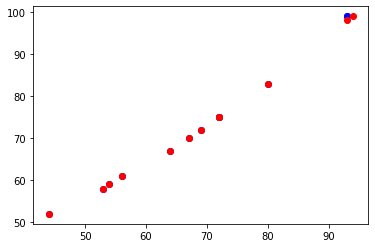

In [9]:
plt.scatter(school_score_tied, moderated_tied, c='blue')
plt.scatter(school_score_sep, moderated_sep, c='red')


Compare the result for each student under each scenario. 

In [10]:
compare_tied_sep = moderated_sep - moderated_tied
print(f'Effect on moderated mark as a result of spearating the top students. Listed in reverse rank order')
print(f'{compare_tied_sep}')

Effect on moderated mark as a result of spearating the top students. Listed in reverse rank order
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]


Now lets do this `runs` times and see who the winners and losers are.

Text(0.5, 1.0, 'Effect of separating tied first placegetters')

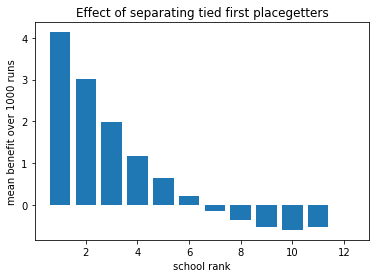

In [14]:
runs = 1000
compare_cumulative = np.empty(n)

for r in range(runs):
    school_scores = np.random.normal(mean, sd, n-1)
    school_scores = np.rint(school_scores) #convert to integer scores
    # make sure no value is greater than school_max
    school_scores = np.minimum(school_scores, school_max-1)
    school_scores = np.sort(school_scores)
    
    school_score_tied = np.append(school_scores, np.amax(school_scores))
    school_score_sep = np.append(school_scores, np.amax(school_scores)+1)
    
    exam_scores = school_score_tied + np.random.normal(mean_imp, sd_imp, n)
    exam_scores = np.minimum(exam_scores, 99)
    exam_scores = np.rint(exam_scores)

    stats_tied = get_stats(school_score_tied)
    stats_sep = get_stats(school_score_sep)
    stats_exam = get_stats(exam_scores)
    stats_exam_tied = get_stats(exam_scores, tied=True)

    #calculate the polynomial coefficients
    poly_fit_tied = np.polyfit(stats_tied, stats_exam_tied, 2)
    poly_fit_sep = np.polyfit(stats_sep, stats_exam, 2)

    moderated_tied = poly_fit_tied[0]*np.power(school_score_tied, 2)+ poly_fit_tied[1]*school_score_tied + poly_fit_tied[2]
    moderated_tied = np.rint(moderated_tied)
    moderated_sep = poly_fit_sep[0]*np.power(school_score_sep, 2)+ poly_fit_sep[1]*school_score_sep + poly_fit_sep[2]
    moderated_sep = np.rint(moderated_sep)
    compare_tied_sep = moderated_sep - moderated_tied

    compare_cumulative = compare_cumulative + compare_tied_sep

compare_cumulative = np.flip(compare_cumulative)
plt.bar(np.arange(n) + 1, compare_cumulative / runs)
plt.xlabel('school rank')
plt.ylabel(f'mean benefit over {runs} runs')
plt.title('Effect of separating tied first placegetters')

## Interpretation of results

The plot above shows the mean benefit by rank for the multiple runs. Each time this analysis hase been run, it is clear that separating tied students benefits the group overall, but the benefit is significantly skewed towards the better ranked students at the expense of those with lower ranks. Splitting top students who would otherwise be tied has no educational justification, but teachers may be able to justify it on the basis of an overall benefit to the class. However they need to acknowledge that by doing so they are in all likelyhood disadvantaging the lower ranked students.

"to the one who has, more will be given, and from the one who has not, even what he thinks that he has will be taken away."